In [1]:
import numpy as np; np.random.seed(1337)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

import h5py
from sklearn.metrics import roc_curve, auc

2023-07-05 12:43:44.406707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 12:43:44.890200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
# Keras model parameters
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024*100     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024*5     # Test size
epochs      = 20       # Number of epochs
doGPU       = True     # Use GPU

In [22]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

2023-07-05 12:49:47.080677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:49:47.080963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:49:47.081145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
# Load image data
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'Particle_Images/data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    print(len(y))
    assert len(X) == len(y)
    return X, y

In [24]:
# Split training / validation / test sets
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

204800
2048
10240


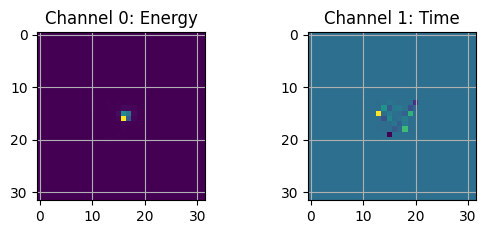

In [25]:
# plot sample of traiing images
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

In [26]:
# Define CNN model
model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

2023-07-05 12:50:01.155256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:50:01.155481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:50:01.155633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-4)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=20,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

2023-07-05 12:50:55.065300: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1677721600 exceeds 10% of free system memory.
2023-07-05 12:50:55.775349: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1677721600 exceeds 10% of free system memory.


Epoch 1/20
3200/3200 [==============================] - 14s 5ms/step - loss: 0.5658 - accuracy: 0.7152 - val_loss: 0.5710 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 2/20
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5604 - accuracy: 0.7186 - val_loss: 0.5566 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/20
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5567 - accuracy: 0.7217 - val_loss: 0.5600 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 4/20
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5534 - accuracy: 0.7248 - val_loss: 0.5576 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 5/20
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5404 - accuracy: 0.7334 - val_loss: 0.5447 - val_accuracy: 0.7456 - lr: 2.0000e-04
Epoch 6/20
3200/3200 [==============================] - 15s 5ms/step - loss: 0.5380 - accuracy: 0.7351 - val_loss: 0.5456 - val_accuracy: 0.7402 - lr: 2.0000e-04
Epoch 7/20
3200/3200 [======================

In [29]:
# evaluate the model
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 0s 3ms/step - loss: 0.5442 - accuracy: 0.7349

Validation loss / accuracy: 0.5442 / 0.7349
64/64 [==============================] - 0s 1ms/step
Validation ROC AUC: 0.8013343811035156
320/320 [==============================] - 1s 3ms/step - loss: 0.5414 - accuracy: 0.7313

Test loss / accuracy: 0.5414 / 0.7313
320/320 [==============================] - 0s 1ms/step
Test ROC AUC: 0.8020424461364748


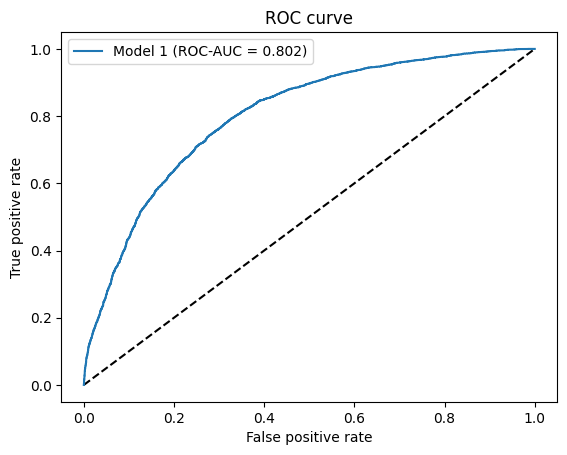

In [30]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()